In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run 0_parameters.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      


ModuleNotFoundError: No module named 'easydict'

In [3]:
figname = '../paper/fig_methods'

# Definition of the input and the output 

## Representation of input image (retina)

In [4]:
from retina import Display
d = Display(args)

In [5]:
from retina import Retina
r = Retina(args)

In [6]:
data, label = next(iter(d.loader_test))
idx = 4
data_fullfield, i_offset, j_offset = d.draw(data[idx, 0, :, :].numpy())
data_retina = r.retina(data_fullfield)


In [7]:
#data_fullfield, i_offset, j_offset = d.draw(data[idx, 0, :, :].numpy(), noise=0, contrast=1)
#def place_object(data, i_offset, j_offset, im_noise=None, N_pic=128, contrast=1., noise=.5, sf_0=0.1, B_sf=0.1, do_mask=True, do_max=False):
from retina import place_object
im_mnist = place_object(data[idx, 0, :, :], i_offset, j_offset, im_noise=None, N_pic=128, contrast=1., noise=0., sf_0=0.1, B_sf=0.1, do_mask=True, do_max=False)

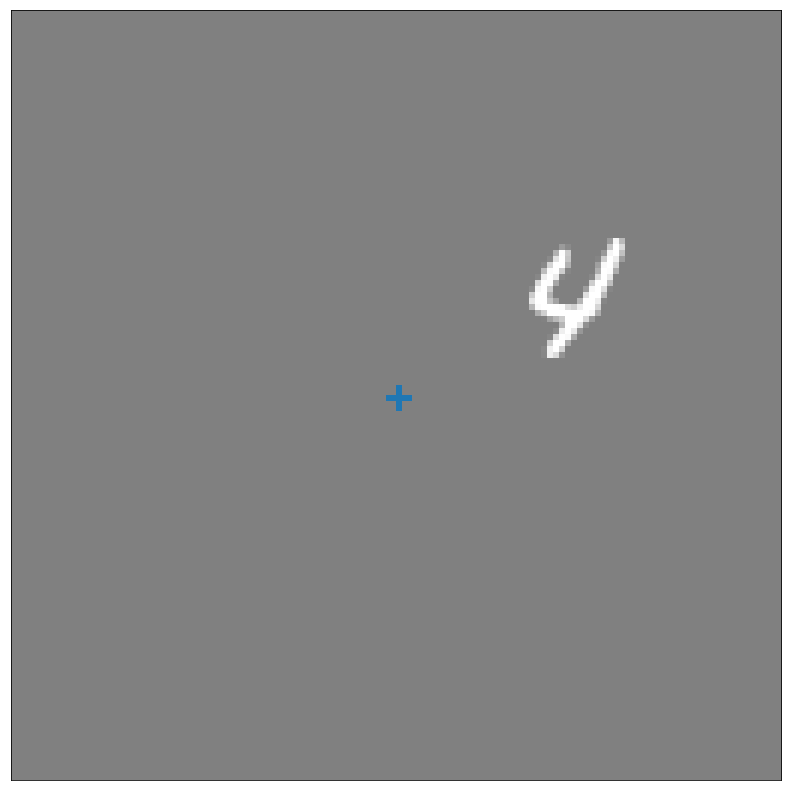

In [8]:
fig, axs = plt.subplots(1, 1, figsize = (figwidth, figwidth))
axs = d.show(axs, im_mnist)

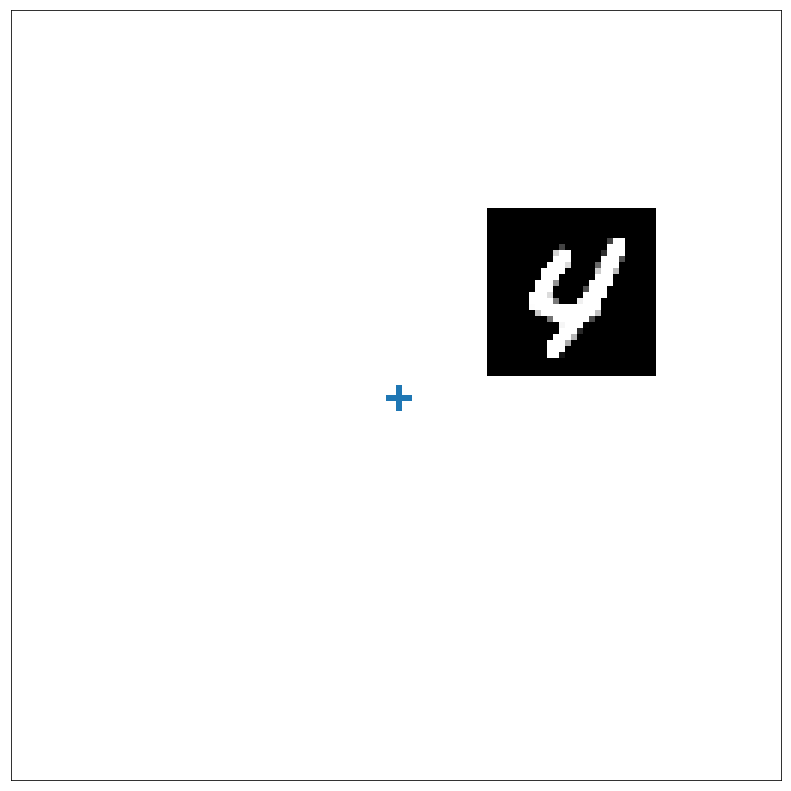

In [9]:
#data_fullfield, i_offset, j_offset = d.draw(data[idx, 0, :, :].numpy(), noise=0, contrast=1)
#def place_object(data, i_offset, j_offset, im_noise=None, N_pic=128, contrast=1., noise=.5, sf_0=0.1, B_sf=0.1, do_mask=True, do_max=False):
from retina import do_offset
im_mnist = do_offset(data[idx, 0, :, :], i_offset=i_offset, j_offset=j_offset, N_pic=128, data_min=2.)

im_mnist[im_mnist==2.] *= np.nan

fig, axs = plt.subplots(1, 1, figsize = (figwidth, figwidth))
axs = d.show(axs, im_mnist)

In [10]:
from retina import MotionCloudNoise
im_noise, _ = MotionCloudNoise(sf_0=args.sf_0, B_sf=args.B_sf)

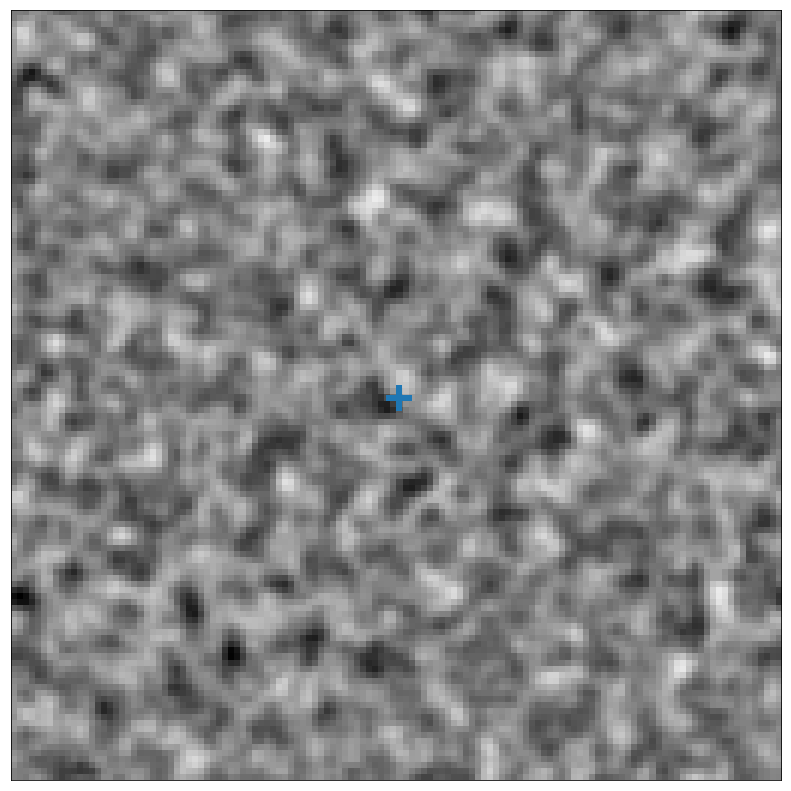

In [11]:
fig, axs = plt.subplots(1, 1, figsize = (figwidth, figwidth))
axs = d.show(axs, im_noise)

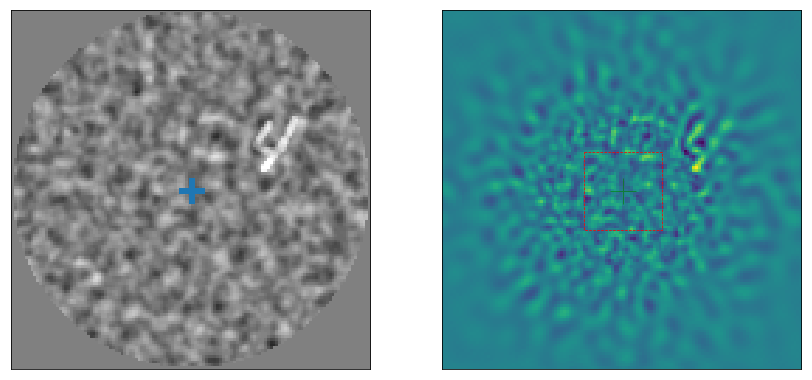

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (figwidth, figwidth/2))
axs[0] = d.show(axs[0], data_fullfield)
axs[1] = r.show(axs[1], r.retina_invert(data_retina))


https://stackoverflow.com/questions/30464117/plotting-a-imshow-image-in-3d-in-matplotlib#30465073

arrows = 
https://stackoverflow.com/questions/29188612/arrows-in-matplotlib-using-mplot3d

In [13]:
args.N_pic


128

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Arrow 
import numpy as np
from matplotlib import cm


class Arrow3D(Arrow):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        Arrow.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        Arrow.draw(self, renderer)
        

In [15]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


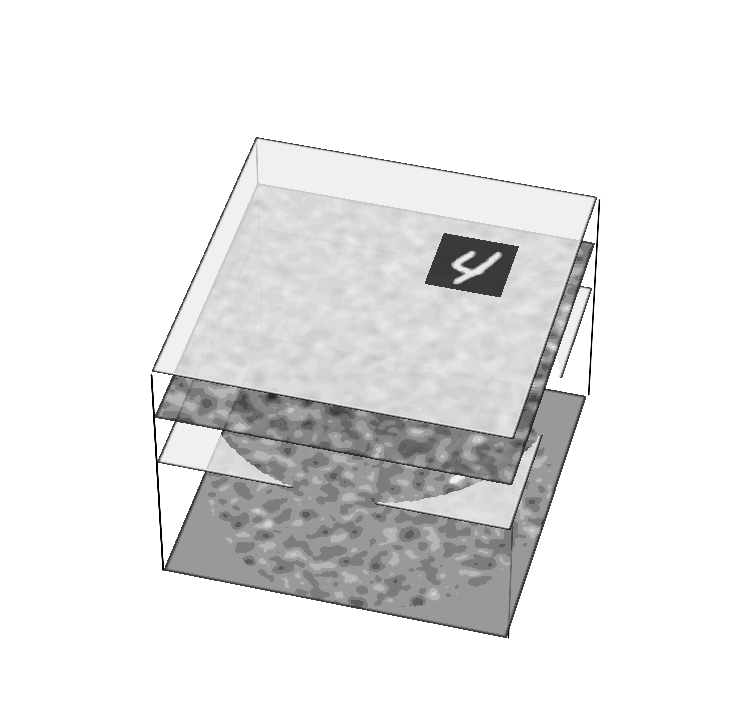

In [16]:
X, Y = np.meshgrid(np.arange(args.N_pic), np.arange(args.N_pic))
mask = np.ones_like(X) * .5
mask[(X-args.N_pic//2)**2 + (Y-args.N_pic//2)**2 <(args.N_pic//2)**2] *= np.nan
mask[0, 0] = 0
mask[127, 0] = 1

contour = np.ones_like(X) * 1.
contour[X==0] *= 0.
contour[X==args.N_pic-1] *= 0.
contour[Y==0] *= 0.
contour[Y==args.N_pic-1] *= 0.


#im_mnist = np.ones_like(X) * 1.
#im_mnist[(X-64)**2 + (Y-64)**2 > 8**2] *= np.nan

# create the figure
fig = plt.figure(figsize=(13, 13))

# show the 3D rotated projection
ax = fig.add_subplot(111, projection='3d')

layers = [0, .25, .35, .45]
N_q = 256
opts = dict(N=N_q, zdir='z', cmap=cm.gray, alpha=.8) # , vmin=-1, vmax=1.
aopts = dict(mutation_scale=20, arrowstyle='-|>', alpha=1., color='r') #,  fill=True, facecolor='b', edgecolor='g')
aopts = dict(alpha=1., color='k') #,  fill=True, facecolor='b', edgecolor='g')

a = Arrow3D([args.N_pic]*2, [0]*2, [max(layers), 0], **aopts)
ax.add_artist(a)

# Hide grid lines
ax.grid(False)
ax.axis("off")
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

cset = ax.contourf(X, Y, data_fullfield.T*contour, offset=0., **opts)
#ax.plot_surface(X, Y, np.zeros_like(X), facecolors=plt.cm.gray( data_fullfield.T*contour))
cset = ax.contourf(X, Y, mask*contour, offset=layers[1], **opts)
cset = ax.contourf(X, Y, im_noise.T*contour, offset=layers[2], **opts)
cset = ax.contourf(X, Y, np.ones_like(contour)*contour, offset=max(layers), **opts)
cset = ax.contourf(X, Y, im_mnist.T*contour, offset=max(layers), **opts)

#ax2.plot_surface(X, Y, data_fullfield, rstride=1, cstride=1, facecolors=plt.cm.gray(data_fullfield), shade=False)
#ax2.imshow(X, Y, data_fullfield, rstride=1, cstride=1, facecolors=plt.cm.gray(data_fullfield), shade=False)
ax.set_zlim((0.,.6))

#a = Arrow3D([j_offset-14, j_offset-14], [i_offset-14, i_offset-14], [.6, .6], mutation_scale=20, arrowstyle='-|>', color='r')
a = Arrow3D([0]*2, [0]*2, [max(layers), 0], **aopts)
ax.add_artist(a)
a = Arrow3D([args.N_pic]*2, [args.N_pic]*2, [max(layers), 0], **aopts)
ax.add_artist(a)
a = Arrow3D([0]*2, [args.N_pic]*2, [max(layers), 0], **aopts)
ax.add_artist(a)
a = Arrow3D([args.N_pic]*2, [0]*2, [max(layers), 0], **aopts)
ax.add_artist(a)
a = Arrow3D([args.N_pic]*2, [0]*2, [max(layers), 0], **aopts)
ax.add_artist(a)
a = Arrow3D([args.N_pic]*2, [0]*2, [max(layers), 0], **aopts)
ax.add_artist(a)

ax.view_init(elev=45., azim=15.)

In [17]:
ax.view_init?

Signature: ax.view_init(elev=None, azim=None)
Docstring:
Set the elevation and azimuth of the axes.

This can be used to rotate the axes programmatically.

'elev' stores the elevation angle in the z plane.
'azim' stores the azimuth angle in the x,y plane.

if elev or azim are None (default), then the initial value
is used which was specified in the :class:`Axes3D` constructor.
File:      /usr/local/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py
Type:      method


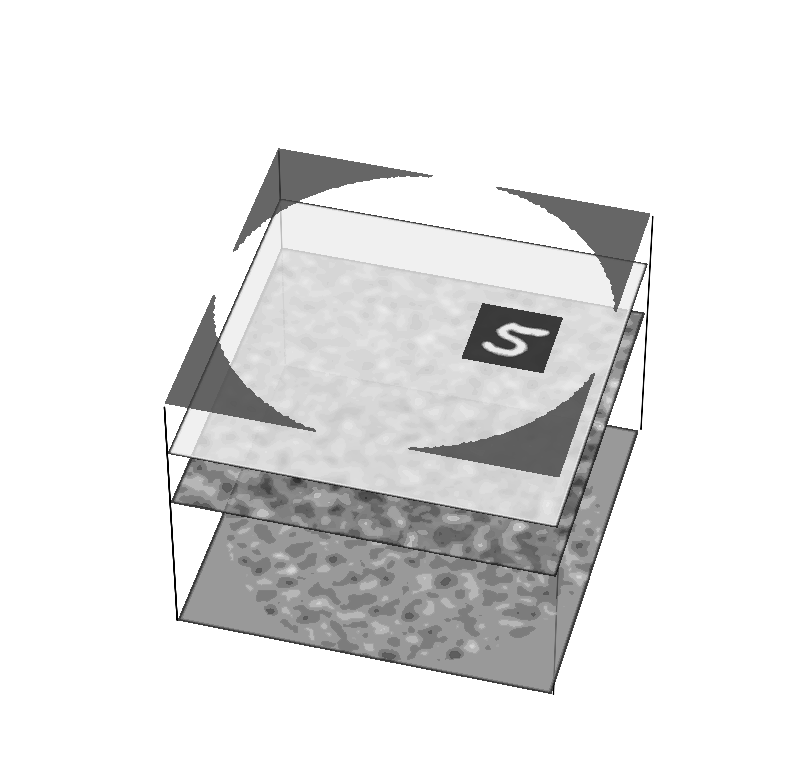

In [18]:
def panel_A(fig=None, ax=None):

    if fig is None:
        fig = plt.figure(figsize=(figwidth, figwidth))
        #fig, ax = plt.subplots(1, 1, figsize = (figwidth, figwidth))
    if ax is None:
        # show the 3D rotated projection
        ax = fig.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(np.arange(args.N_pic), np.arange(args.N_pic))
    mask = np.ones_like(X) * .0
    mask[(X-args.N_pic//2)**2 + (Y-args.N_pic//2)**2 <(args.N_pic//2)**2] *= np.nan
    mask[0, 0] = -1
    mask[127, 0] = 1

    contour = np.ones_like(X) * 1.
    contour[X==0] *= 0.
    contour[X==args.N_pic-1] *= 0.
    contour[Y==0] *= 0.
    contour[Y==args.N_pic-1] *= 0.

    from retina import MotionCloudNoise
    im_noise, _ = MotionCloudNoise(sf_0=args.sf_0, B_sf=args.B_sf)    
    data, label = next(iter(d.loader_test))
    idx = 4
    from retina import do_offset
    im_mnist = do_offset(data[idx, 0, :, :], i_offset=i_offset, j_offset=j_offset, N_pic=128, data_min=2.)

    im_mnist[im_mnist==2.] *= np.nan

    #im_mnist = np.ones_like(X) * 1.
    #im_mnist[(X-64)**2 + (Y-64)**2 > 8**2] *= np.nan

    # show the 3D rotated projection
    ax = fig.add_subplot(111, projection='3d')
    
    layers = [0, .25, .35, .45]
    #a = Arrow3D([j_offset-14, j_offset-14], [i_offset-14, i_offset-14], [.6, .6], mutation_scale=20, arrowstyle='-|>', color='r')
    aopts = dict(mutation_scale=20, arrowstyle='-|>', alpha=1., color='r') #,  fill=True, facecolor='b', edgecolor='g')
    aopts = dict(alpha=1., color='k') #,  fill=True, facecolor='b', edgecolor='g')
    a = Arrow3D([args.N_pic]*2, [0]*2, [max(layers), 0], **aopts)
    ax.add_artist(a)


    N_q = 256
    opts = dict(N=N_q, zdir='z', cmap=cm.gray, alpha=.8) # , vmin=-1, vmax=1.
    cset = ax.contourf(X, Y, data_fullfield.T*contour, offset=0., **opts)
    #ax.plot_surface(X, Y, np.zeros_like(X), facecolors=plt.cm.gray( data_fullfield.T*contour))
    cset = ax.contourf(X, Y, im_noise.T*contour, offset=layers[1], **opts)
    cset = ax.contourf(X, Y, np.ones_like(contour)*contour, offset=layers[2], **opts)
    cset = ax.contourf(X, Y, im_mnist.T*contour, offset=layers[2], **opts)
    cset = ax.contourf(X, Y, mask*contour, offset=layers[3], **opts)

    #ax2.plot_surface(X, Y, data_fullfield, rstride=1, cstride=1, facecolors=plt.cm.gray(data_fullfield), shade=False)
    #ax2.imshow(X, Y, data_fullfield, rstride=1, cstride=1, facecolors=plt.cm.gray(data_fullfield), shade=False)
    ax.set_zlim((0.,.6))

    a = Arrow3D([0]*2, [0]*2, [max(layers), 0], **aopts)
    ax.add_artist(a)
    a = Arrow3D([args.N_pic]*2, [args.N_pic]*2, [max(layers), 0], **aopts)
    ax.add_artist(a)
    a = Arrow3D([0]*2, [args.N_pic]*2, [max(layers), 0], **aopts)
    ax.add_artist(a)
    a = Arrow3D([args.N_pic]*2, [0]*2, [max(layers), 0], **aopts)
    ax.add_artist(a)
    a = Arrow3D([args.N_pic]*2, [0]*2, [max(layers), 0], **aopts)
    ax.add_artist(a)
    a = Arrow3D([args.N_pic]*2, [0]*2, [max(layers), 0], **aopts)
    ax.add_artist(a)        

    # Hide grid lines
    ax.grid(False)
    ax.axis("off")
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.view_init(elev=45., azim=15.)
    
    return fig, ax
fig, ax = panel_A()

fig.savefig('/tmp/panel_A.pdf')

In [19]:
mask*contour

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.5, 0.5, ..., 0.5, 0.5, 0. ],
       [0. , 0.5, 0.5, ..., 0.5, 0.5, 0. ],
       ...,
       [0. , 0.5, 0.5, ..., 0.5, 0.5, 0. ],
       [0. , 0.5, 0.5, ..., 0.5, 0.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

## Representation of output accuracy (colliculus)

In [20]:
path = "../data/MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy_map =  np.load(path)
    if args.verbose:
        print('Loading accuracy... min, max=', accuracy_map.min(), accuracy_map.max())
else:
    print('No accuracy data found.')

Loading accuracy... min, max= 0.0145 0.9852


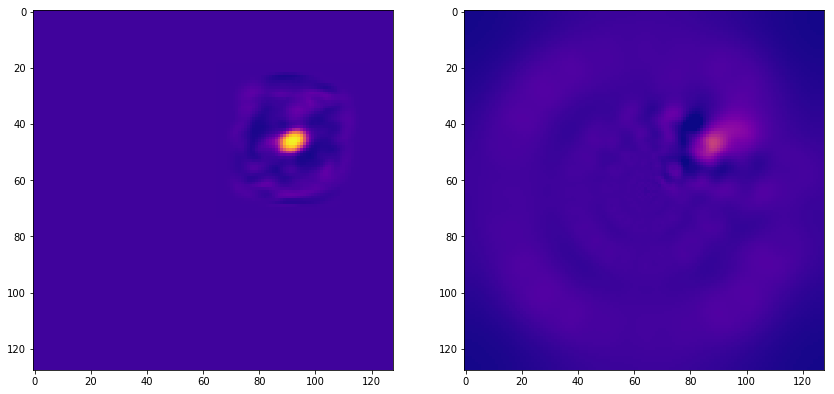

In [21]:
accuracy_colliculus, accuracy_fullfield_map = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)

fig, axs = plt.subplots(1, 2, figsize = (figwidth, figwidth/2))
axs[0].imshow(accuracy_fullfield_map, vmin=0, vmax=1, cmap=plt.plasma())
axs[1].imshow(r.accuracy_invert(accuracy_colliculus), vmin=0, vmax=1, cmap=plt.plasma())


# Evaluating the accuracy of the classifier (What) wrt to spatial shifts

On commence par la fonction de base apprise de la librairie torch, cf https://raw.githubusercontent.com/pytorch/examples/master/mnist/main.py :

In [22]:
%whos

Variable                 Type              Data/Info
----------------------------------------------------
Arrow                    type              <class 'matplotlib.patches.Arrow'>
Arrow3D                  type              <class '__main__.Arrow3D'>
Axes3D                   type              <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>
Display                  type              <class 'retina.Display'>
FancyArrowPatch          type              <class 'matplotlib.patches.FancyArrowPatch'>
MotionCloudNoise         function          <function MotionCloudNoise at 0x11cfa1ea0>
N_q                      int               256
Retina                   type              <class 'retina.Retina'>
X                        ndarray           128x128: 16384 elems, type `int64`, 131072 bytes (128.0 kb)
Y                        ndarray           128x128: 16384 elems, type `int64`, 131072 bytes (128.0 kb)
a                        Arrow3D           Arrow3D((-0.058237, -0.00<...>>(-0.0551856, -0.057869

In [23]:
from what import WhatNet
model = WhatNet()


On apprend une matrice de poids qui est fixée dans la suite et que nous allons utiliser pour la classification

In [24]:
%ls -ltr ../data/MNIST_cnn.pt
#%rm -f ../data/MNIST_cnn.pt

-rw-r--r--  1 laurentperrinet  staff  1736289 Mar 14 12:31 ../data/MNIST_cnn.pt


In [25]:
model_path = "../data/MNIST_cnn.pt"

import os
import torch
if os.path.isfile(model_path):
    print('Loading')
    model = torch.load(model_path)
    #model.load_state_dict(torch.load(model_path))
else:
    print('Learning')
    import time
    t0 = time.time()
    %run what.py --epochs 10 --save-model
    print('Done in ', time.time() - t0, 'seconds')

Loading


In [26]:
from main import init
#args = init(filename='debug')
#args = init(filename='../data/2019-03-19_bis')
#args = init()
args = init(filename='../data/2019-04-15_bis', verbose=1)

from where import Where
from what import WhatNet
where = Where(args)

Loading accuracy... min, max= 0.0145 0.9852
Loading training dataset
Done!
Loading testing dataset


In [27]:
filename_train = args.filename + '_train.pt'
#filename_train = "../data/2019-03-14_train4.pt"
#filename_train = "../data/2019-03-29.pt"
#%ls -lh {filename_train}
#%rm {filename_train}
#%rm  ../data/debug_train.pt

where.train(filename_train)

[autoreload of urllib3.packages.six failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 331, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 274, in update_class
    old_obj = getattr(old, key)
  File "/usr/local/lib/python3.7/site-packages/urllib3/packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of urllib3.util failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py

Model saved at ../data/2019-04-15_bis_train.pt


## Using the learned classifier in a standalone class

Maintenant qu'on a appris les points qui permet une classification d'à peu près 98 % on va utiliser le modèle fead-forward pour faire la classification.

In [28]:
from retina import Display
d = Display(args)
data, label = next(iter(d.loader_test))

## shifting the input images


Je vais maintenant générer des données en utilisant les données originales de MNIST translatées :

In [29]:
from torchvision import datasets, transforms
i_shift, j_shift = 12, 17
N_pix = 28

In [30]:
from retina import Display
d = Display(args)
data, label = next(iter(d.loader_test))

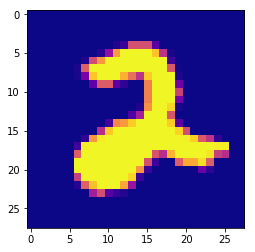

In [31]:
fig, ax = plt.subplots()
ax.imshow(data[0, 0, :, :].numpy())

(10000, 1, 82, 82)


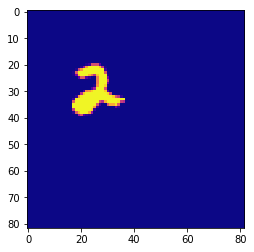

In [32]:
data = data.numpy()
data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 2, N_pix*3 - 2))
print(data_translate.shape)
data_translate[:, :, (N_pix-i_shift):(2*N_pix-i_shift), (N_pix-j_shift):(2*N_pix-j_shift)] = data
fig, ax = plt.subplots()
ax.imshow(data_translate[0, 0, :, :])

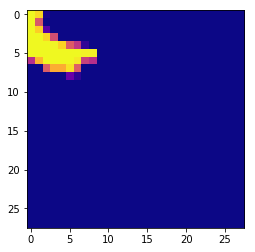

In [33]:
data_cropped = data_translate[:, :, (N_pix):(2*N_pix), (N_pix):(2*N_pix)]
fig, ax = plt.subplots()
ax.imshow(data_cropped[0, 0, :, :])

In [34]:
np.arange(-N_pix+1, N_pix)

array([-27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15,
       -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,
        -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27])

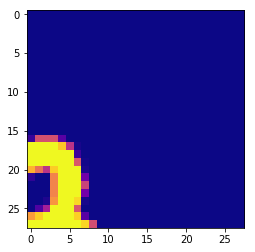

In [35]:
def shift_data(data, i_shift, j_shift):
    N_pix = data.shape[-1]
    assert(N_pix == data.shape[-2])
    import numpy as np
    data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 1, N_pix*3 - 1))
    data_translate[:, :, (N_pix+i_shift):(2*N_pix+i_shift), (N_pix+j_shift):(2*N_pix+j_shift)] = data
    data_cropped = data_translate[:, :, (N_pix):(2*N_pix), (N_pix):(2*N_pix)]
    return data_cropped

data_cropped = shift_data(data, i_shift = 12, j_shift = -12)
fig, ax = plt.subplots()
ax.imshow(data_cropped[0, 0, :, :])

## Using the learned classifier on the shifted data

On peut maintenant tester le classifieur sur les images Translatées en calculant la valeur de classification en  fonction de l'erreur de localisation

In [36]:
def test_shift(test_loader, i_shift, j_shift, verbose=0):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data_cropped = shift_data(data, i_shift=i_shift, j_shift=j_shift)        
        data_cropped = torch.FloatTensor(data_cropped) #transforms.ToTensor()(data_cropped)
        data_cropped, target = Variable(data_cropped, volatile=True), Variable(target)
        output = model(data_cropped)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    if verbose: print('\nTest set: at ({}, {}), the  average loss is {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        i_shift, j_shift, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


path = "../data/MNIST_accuracy.npy"

import os
if os.path.isfile(path):
    print('Loading accuracy')
    accuracy = np.load(path)
else:
    print('Computing accuracy')
    import time
    t0 = time.time()
    accuracy = np.zeros((2*N_pix-1, 2*N_pix-1))
    from tqdm import tqdm
    N_step = 1

    with tqdm(total=(2*N_pix-1)**2/N_step**2) as pbar:
        for i_shift in np.arange(-N_pix+1, N_pix, N_step):
            for j_shift in np.arange(-N_pix+1, N_pix, N_step):
                accuracy[i_shift+N_pix-1, j_shift+N_pix-1] = test_shift(test_loader, i_shift, j_shift)
                pbar.update()
    np.save(path, accuracy)
    print('Done in ', time.time() - t0, 'seconds')
    
print('accuracy=', accuracy)    

Loading accuracy
accuracy= [[0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 ...
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]]


J'avoue que c'est un peu bourrin de calculer la classification sur les 128 × 128 pixels pour 1000 batch multiplié par 10 type d'entrées.... Mais bon on doit faire ça seulement une fois :-) (et sur CPU une classif = environ 300µs ...)

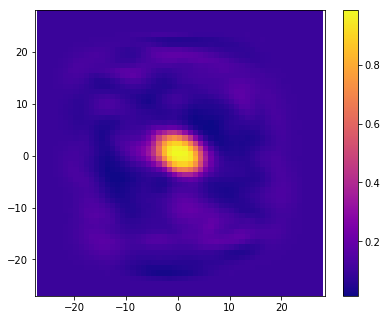

In [37]:
fig, ax = plt.subplots(figsize=(6.5, 5.25))
cmap = ax.pcolor(np.arange(-N_pix+1, N_pix+1), np.arange(-N_pix+1, N_pix+1), accuracy, cmap=plt.plasma())
ax.axis('equal')
fig.colorbar(cmap)
fig.savefig('/tmp/panel_C.pdf', bbox_inches='tight', pad_inches=0.1)

Cette fonction de performance du classifieur  est calculée indépendamment de la forme spécifique du chiffre entre 0 et 9. Elle donne donc la carte de performance qu'on attend Au niveau de la classification/ On va pouvoir maintenant l'utiliser ceomm label pour apprendre de façon supervisée la correspondance entre la carte log-polaire obtenue depuis l'image brute et cette carte de performance.

# Retinotopic mapping

## Orientation invariant power encoding (colliculus??)

In [38]:
from retina import Retina
r = Retina(args)

In [39]:
print('r.colliculus.shape=', r.colliculus.shape)

r.colliculus.shape= (24, 10, 16384)


In [40]:
print('r.colliculus_vector.shape=', r.colliculus_vector.shape)

r.colliculus_vector.shape= (240, 16384)


In [41]:
print('r.colliculus_inverse.shape=', r.colliculus_inverse.shape)

r.colliculus_inverse.shape= (16384, 240)


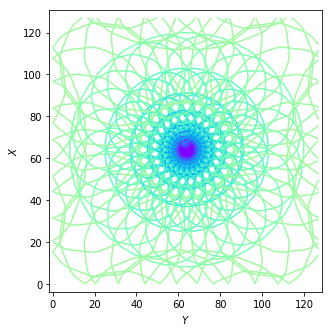

In [42]:
energy = (r.retina_transform**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((args.N_azimuth*args.N_eccentricity, args.N_pic**2))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(figwidth/3, figwidth/3))
for i_orient in range(args.N_azimuth):
    for i_scale in range(args.N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((args.N_pic, args.N_pic))
        ax.contour(energy[i_orient, i_scale, :].reshape((args.N_pic, args.N_pic)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/args.N_azimuth)])
#fig.suptitle('Tiling of visual space using energy', y=1.02)
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()
fig.savefig('/tmp/panel_B.pdf')

# summary


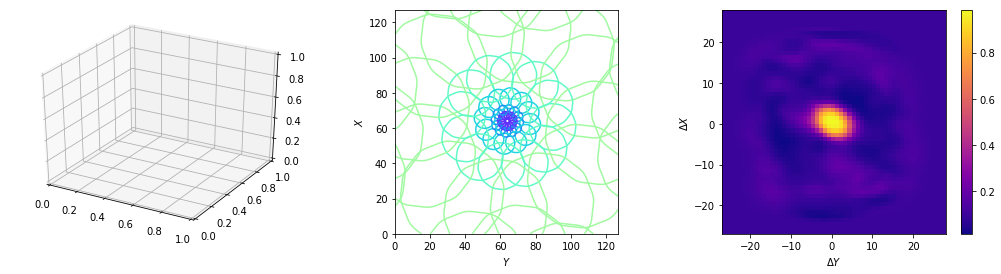

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (figwidth, figwidth/3.618))
ax_A = plt.subplot(1, 3, 1, projection='3d')

fig, ax_A = panel_A(fig, ax_A)
#data_retina = where.retina.retina(full[idx]['data_fullfield'])
#ax_A = where.retina.show(ax_A, where.retina.retina_invert(data_retina))
    

ax_B = plt.subplot(1, 3, 2)
for i_orient in range(0, args.N_azimuth, 2):
    for i_scale in range(1, args.N_eccentricity, 2):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((args.N_pic, args.N_pic))
        ax_B.contour(energy[i_orient, i_scale, :].reshape((args.N_pic, args.N_pic)), levels=[env.max()/2], lw=.1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/args.N_azimuth)])
ax_B.set_xlabel(r'$Y$')
ax_B.set_ylabel(r'$X$')
ax_B.axis('square')

ax_C = plt.subplot(1, 3, 3)
cmap = ax_C.pcolor(np.arange(-N_pix+1, N_pix+1), np.arange(-N_pix+1, N_pix+1), accuracy, cmap=plt.plasma())
ax_C.axis('square')
ax_C.set_xlabel(r'$\Delta Y$')
ax_C.set_ylabel(r'$\Delta X$')
fig.colorbar(cmap)


#for ax, text, x_offset, y_offset in [[ax_A, 'A', -.35, .95], [ax_B, 'B', -.35, .95], [ax_C, 'C', -.35, .95]]:
#    ax.text(x_offset, y_offset, '(' + text + ')', fontsize=24,
#              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
#              ha='left', va='center', transform=ax.transAxes) 
plt.tight_layout()

fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

In [44]:
import tikzmagic

In [45]:
%load_ext tikzmagic

In [46]:
%ls /tmp/panel*

/tmp/panel_A.pdf  /tmp/panel_B.pdf  /tmp/panel_C.pdf


In [47]:
%%tikz -f pdf --save {figname}.pdf
\draw[white, fill=white] (0.\linewidth,0) rectangle (1.\linewidth, .382\linewidth) ;
\draw [anchor=north west] (.0\linewidth, .382\linewidth) node {\includegraphics[width=.33\linewidth]{/tmp/panel_A.pdf}};
\draw [anchor=north west] (.333\linewidth, .382\linewidth) node {\includegraphics[width=.31\linewidth]{/tmp/panel_B.pdf}};
\draw [anchor=north west] (.666\linewidth, .382\linewidth) node {\includegraphics[width=.35\linewidth]{/tmp/panel_C.pdf}};
\begin{scope}[font=\bf\sffamily\large]
\draw [anchor=west,fill=white] (.0\linewidth, .382\linewidth) node [above right=-3mm] {$\mathsf{D}$};
\draw [anchor=west,fill=white] (.36\linewidth, .382\linewidth) node [above right=-3mm] {$\mathsf{E}$};
\draw [anchor=west,fill=white] (.69\linewidth, .382\linewidth) node [above right=-3mm] {$\mathsf{F}$};
\end{scope}

# post-processing

In [48]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

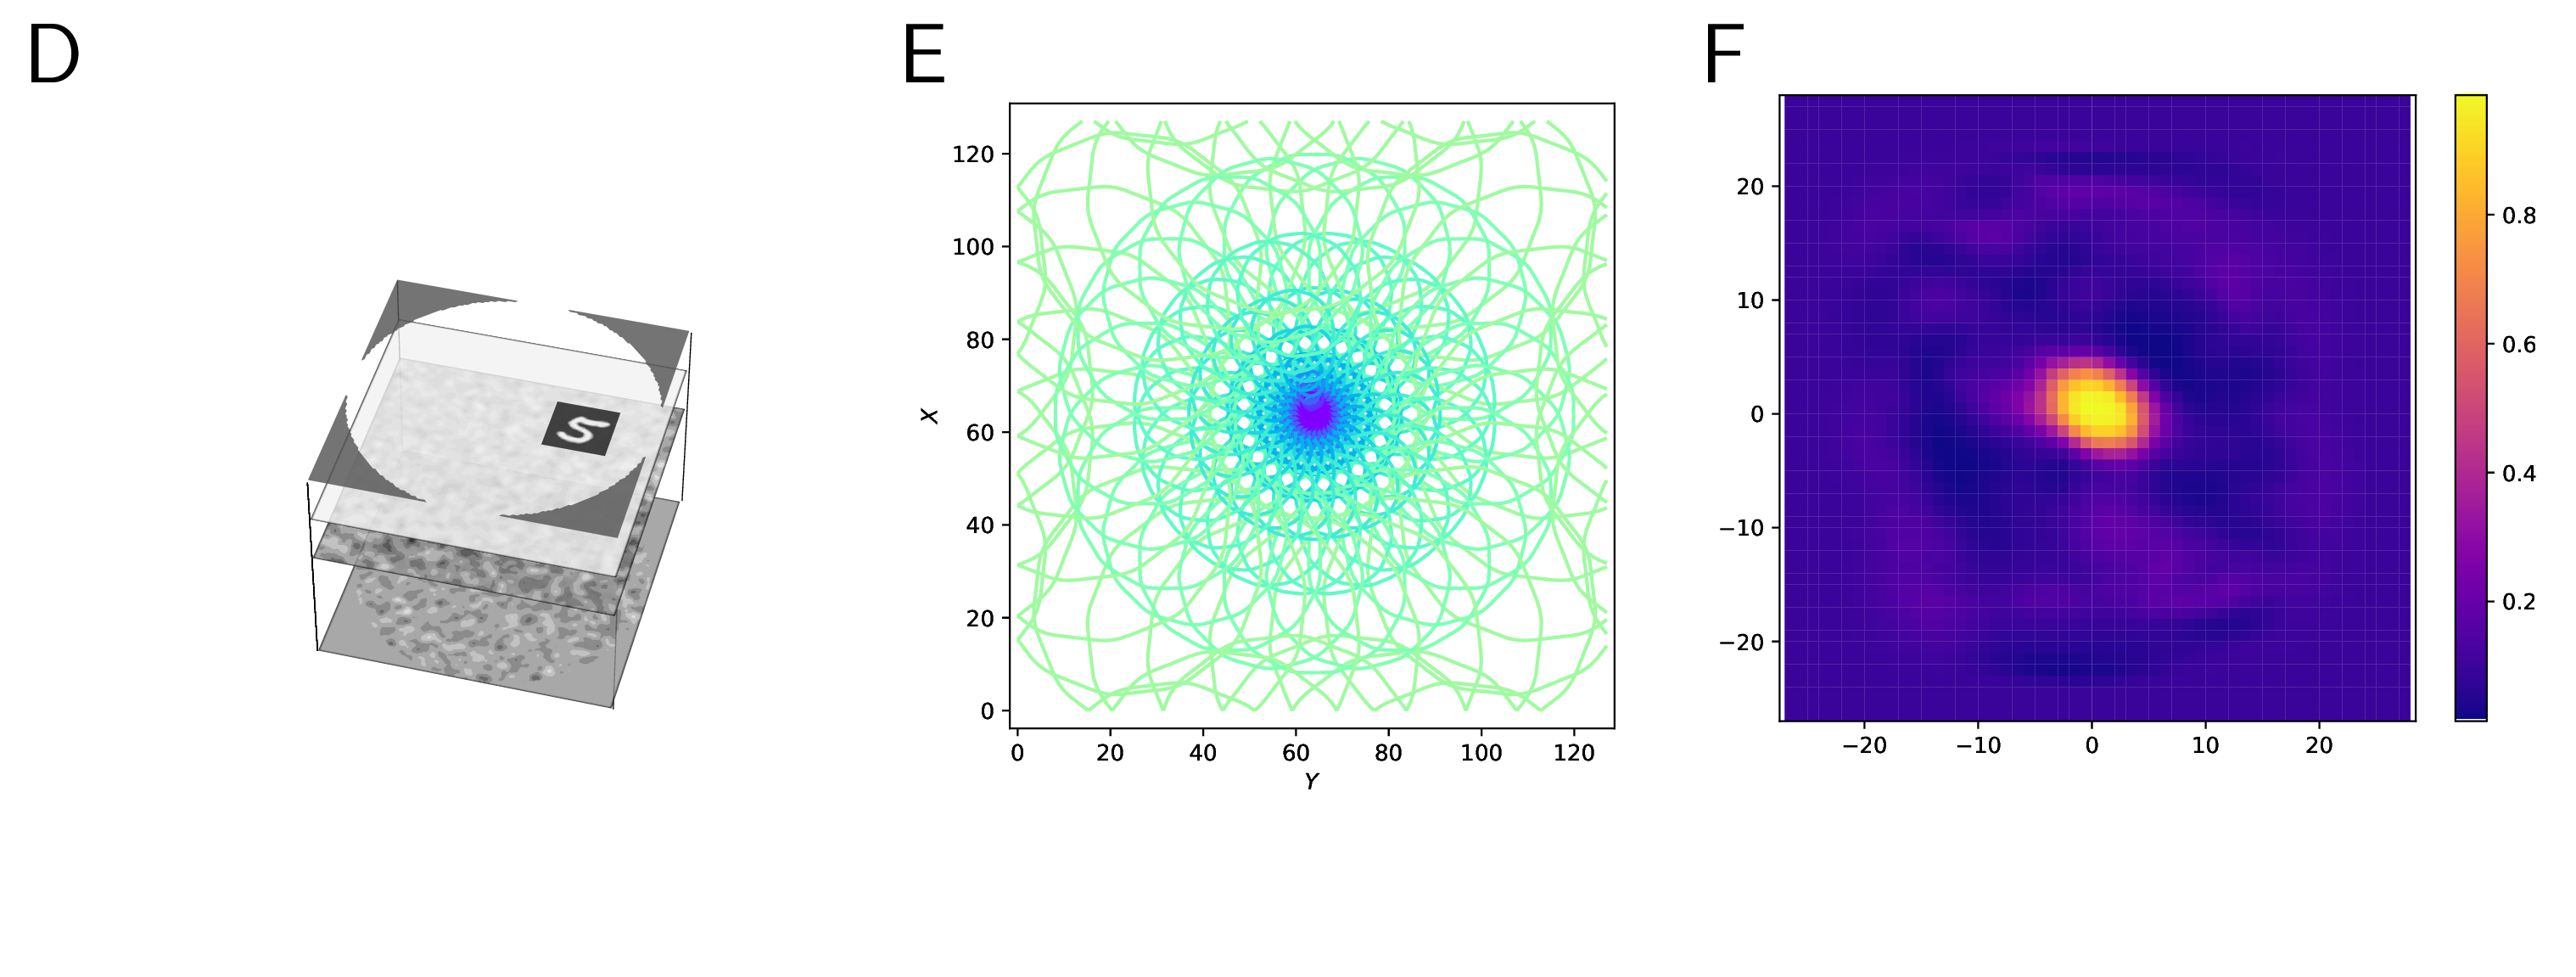

In [49]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [50]:
!ls  -l {figname}*

-rw-r--r--  1 laurentperrinet  staff  549827 Apr 25 17:18 ../paper/fig_methods.jpg
-rw-r--r--  1 laurentperrinet  staff  675259 Apr 25 17:18 ../paper/fig_methods.pdf
-rw-r--r--  1 laurentperrinet  staff  549544 Apr 25 17:18 ../paper/fig_methods.png
